In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf

In [21]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
ids = test['Id']
test.drop(columns='Id', inplace=True)
stores = pd.read_csv("store.csv")

/tmp/ipykernel_423918/1578143300.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


In [22]:
test['Open'] = test['Open'].fillna(test.groupby('DayOfWeek')['Open'].transform(lambda x: x.mode()[0]))
df = pd.concat([train, test])
df.reset_index(inplace=True, drop=True)

In [23]:
df = df.merge(stores, on='Store', how='left')
df.drop(columns=["Customers"], inplace=True)
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df.groupby('StoreType')['CompetitionDistance'].transform('mean'))
df['StateHoliday'][df['StateHoliday'] == '0'] = "None"
df['StateHoliday'][df['StateHoliday'] == 0] = "None"

/tmp/ipykernel_423918/4119447751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StateHoliday'][df['StateHoliday'] == '0'] = "None"
/tmp/ipykernel_423918/4119447751.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StateHoliday'][df['StateHoliday'] == 0] = "None"


In [24]:
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(df.groupby('StoreType')['CompetitionOpenSinceMonth'].transform(lambda x: x.mode()[0]))
df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(df.groupby('StoreType')['CompetitionOpenSinceYear'].transform(lambda x: x.mode()[0]))
df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(df.groupby('StoreType')['Promo2SinceWeek'].transform('mean'))
df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(df.groupby('StoreType')['Promo2SinceYear'].transform('mean'))
df['PromoInterval'] = df['PromoInterval'].fillna(df.groupby('StoreType')['PromoInterval'].transform(lambda x: x.mode()[0]))

In [25]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [26]:
dates = df['Date'].sort_values().unique()
days = range(1, len(dates)+1)
days = pd.DataFrame({"Date": dates, "Day": days})
df = df.merge(days, on="Date", how="left")

#df = df.sort_values(by='Date')

<Axes: xlabel='Date'>

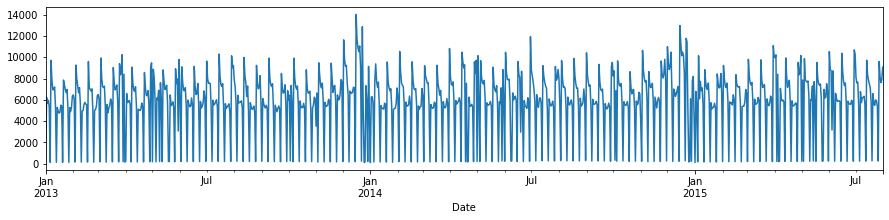

In [27]:
average_sale = df[:len(train)].groupby("Date")['Sales'].mean()

average_sale.plot(figsize=(15, 3))

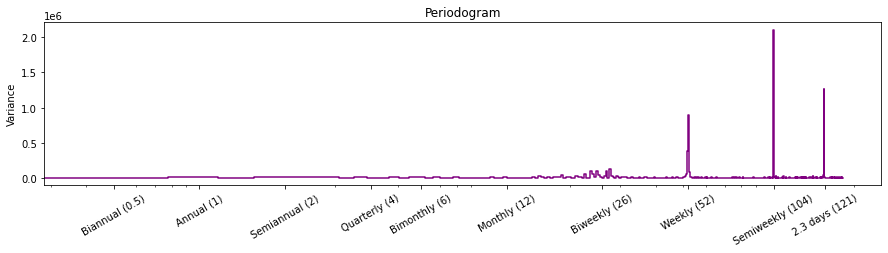

In [28]:
freqencies, spectrum = periodogram(
        average_sale,
        fs=365,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )

plt.figure(figsize=(15, 3))
plt.step(freqencies, spectrum, color="purple")
plt.xscale("log")
plt.xticks([0.5, 1, 2, 4, 6, 12, 26, 52, 104, 158],
          [
        "Biannual (0.5)",
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
        "2.3 days (121)"
    ],rotation=30)
plt.ylabel("Variance")
plt.title("Periodogram")
plt.show()

In [29]:
Seasonality = dict(zip(
    (2.3, 3.5, 7),
    ('2.3_days', 'Semiweek', 'Week')
))

for s, n in Seasonality.items():
    df[f'sin_{n}'] = np.sin(df['Day'] * (2*np.pi / s))
    df[f'cos_{n}'] = np.cos(df['Day'] * (2*np.pi / s))

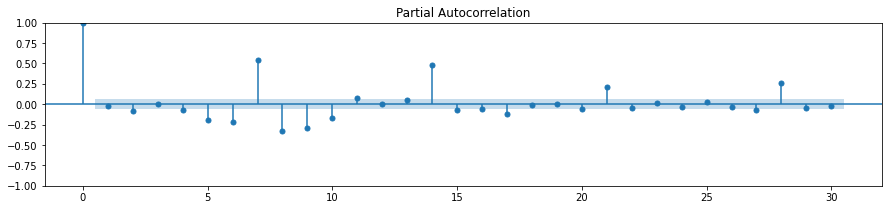

In [30]:
fig, ax = plt.subplots(1,1, figsize=(15,3))
plot_pacf(average_sale, ax=ax)
plt.show()

In [119]:
lags = [5, 6, 7, 8, 9, 10, 10, 14, 21, 28]

In [120]:
budu = df[df['Store']==1].drop(columns='Store')

In [121]:
budu = budu.sort_values(by="Date")

In [122]:
lagged = pd.concat({
    f'lag_{lag}': budu['Sales'].shift(lag)
    for lag in lags
}, axis=1)

In [123]:
budu = pd.concat([budu, lagged], axis=1)[28:]

In [130]:
budu['Sales'].loc[len(train):]

1017209   NaN
Name: Sales, dtype: float64

In [131]:
budu

,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,cos_Week,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_14,lag_21,lag_28
984875,2,2013-01-29,3725.0,1.0,0,None,0,c,a,1270.0,...,0.623490,5195.0,5578.0,5720.0,5394.0,0.0,5182.0,3900.0,5580.0,0.0
983760,3,2013-01-30,4601.0,1.0,0,None,0,c,a,1270.0,...,-0.222521,5586.0,5195.0,5578.0,5720.0,5394.0,0.0,4008.0,5471.0,5530.0
982645,4,2013-01-31,4709.0,1.0,0,None,0,c,a,1270.0,...,-0.900969,5598.0,5586.0,5195.0,5578.0,5720.0,5394.0,4044.0,4892.0,4327.0
981530,5,2013-02-01,5633.0,1.0,0,None,0,c,a,1270.0,...,-0.900969,0.0,5598.0,5586.0,5195.0,5578.0,5720.0,4127.0,4881.0,4486.0
980415,6,2013-02-02,5970.0,1.0,0,None,0,c,a,1270.0,...,-0.222521,4055.0,0.0,5598.0,5586.0,5195.0,5578.0,5182.0,4952.0,4997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020633,7,2015-09-13,NaN,0.0,0,None,0,c,a,1270.0,...,0.623490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1019777,1,2015-09-14,NaN,1.0,1,None,0,c,a,1270.0,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1018921,2,2015-09-15,NaN,1.0,1,None,0,c,a,1270.0,...,0.623490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1018065,3,2015-09-16,NaN,1.0,1,None,0,c,a,1270.0,...,-0.222521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
df_dummy = pd.get_dummies(df)

X_test = df_dummy[len(train):].drop(columns='Sales').set_index("Date")
df_train = df_dummy[:len(train)].sort_values(by='Date').set_index("Date")

In [149]:
from sklearn.preprocessing import StandardScaler

X = df_train.drop(columns='Sales')
y = df_train['Sales']

#X = X['Day'].to_frame()
# X = X[['Day', 'sin_2.3_days', 'DayOfWeek',
#        'cos_2.3_days', 'sin_Semiweek', 'cos_Semiweek', 'sin_Week', 'cos_Week', 'sin_Annual', 'cos_Annual']]

features = X.columns.values
dates = X.index.values

Scaler = StandardScaler()
Scaler.fit(X)
# X = Scaler.transform(X)
# X = pd.DataFrame(X, columns=features, index=dates)

# test_features = X_test.columns.values
# test_dates = X_test.index.values

# X_test = Scaler.transform(X_test)
# X_test = pd.DataFrame(X_test, columns=test_features, index=test_dates)

n = len(X)
X_train = X[:int(0.7*n)]
X_valid = X[int(0.7*n):]
y_train = y[:int(0.7*n)]
y_valid = y[int(0.7*n):]

In [150]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

# model = XGBRegressor()
# model.fit(X_train, y_train)

print("XGB Training error: ", model.score(X_train, y_train))
print("XGB Test error: ", model.score(X_valid, y_valid))

model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

print("\nRidge Training error: ", model_ridge.score(X_train, y_train))
print("Ridge Test error: ", model_ridge.score(X_valid, y_valid))

XGB Training error:  0.6061958114213732
XGB Test error:  0.5861027357519824

Ridge Training error:  0.5747368824294752
Ridge Test error:  0.5872248254854352


In [151]:
y_pred = pd.Series(model_ridge.predict(X_valid), index=X_valid.index)

<Axes: xlabel='Date'>

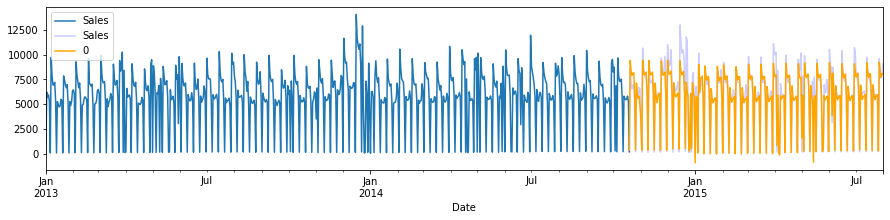

In [153]:
ax = y_train.reset_index().groupby("Date").mean().plot(figsize=(15,3))
y_valid.reset_index().groupby("Date").mean().plot(ax=ax, alpha=0.2, c='blue')
y_pred.reset_index().groupby("Date").mean().plot(ax=ax, c='orange')

In [87]:
final_model = XGBRegressor()
final_model.fit(X, y)

In [85]:
y_test_pred = pd.Series(final_model.predict(X_test), index=X_test.index)

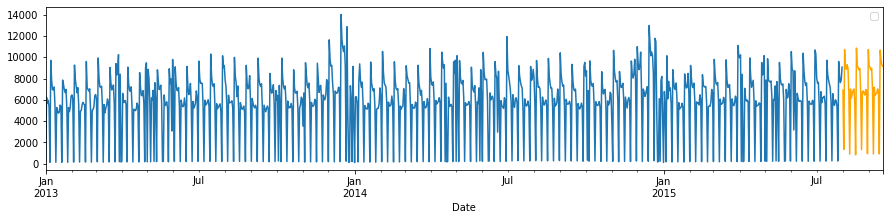

In [88]:
ax = y.reset_index().groupby("Date").mean().plot(figsize=(15,3))
y_test_pred.reset_index().sort_values(by='Date').groupby("Date").mean().plot(ax=ax, c='orange')
ax.legend([])